# Kaggle Competition - KaKR project

In [2]:
# 시각화를 위한 matplotlib import 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 필요 라이브러리 import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# 데이터 경로 지정
data_dir = os.getenv('HOME')+'/aiffel/e/e08_kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### data preprocessing

In [4]:
# date 전처리해주기 (to int)
# 모델이 date 또한 예측을 위한 특성으로 활용할 수 있다
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
# 타겟 데이터에 해당하는 price 컬럼 저일하기
# y 변수에 price를 넣어두고 train에선 삭제하기
y = train['price']
del train['price']

print(train.columns)

# id컬럼도 삭제해두기
del train['id']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
# 위 작업을 test데이터에 대해서도 동일하게!
# 단, price가 없으므로 price처리는 해주지 않아도 된다
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

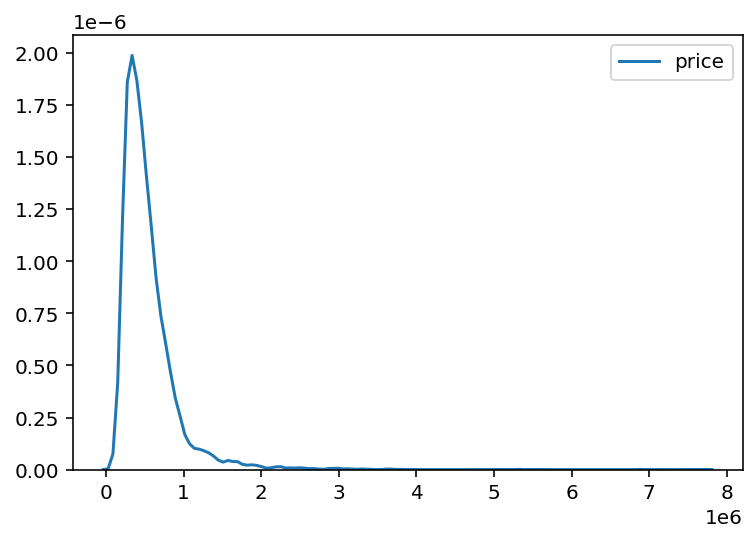

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [9]:
# 가격 데이터 분포 확인하기
sns.kdeplot(y)
plt.show()
# ==> 왼쪽으로 크게 치우쳐 있는 형태를 보인다

y = np.log1p(y)
y

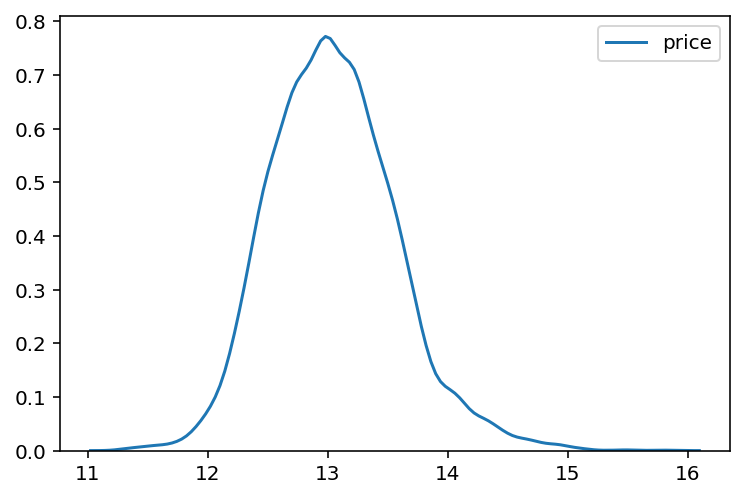

In [10]:
sns.kdeplot(y)
plt.show()

In [11]:
# info()함수로 전체 데이터의 자료형을 한 눈에 확인한다
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [13]:
# RMSE 계산
# 필요 라이브러리 import
# train/test/valid dataset으로 나누기 위한 train_test_split, RMSE점수 계산을 위한 mean_squared_error import

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# RMSE
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 모델 가져오기

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [15]:
# models list 입력
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

# 각 모델의 이름 얻는 법) 클래스의 __name__속성에 접근
gboost.__class__.__name__

'GradientBoostingRegressor'

In [16]:
# 간단히 네 가지 모델에 대해 모두 RMSE값을 빠르게 얻을 수 있음
# get_scores(models, train, y)함수로 만들어보기
def get_scores(models, train, y):
    df = {}
    for m in models:
      m_name = m.__class__.__name__
      
      X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
      m.fit(X_train, y_train)
      y_pred = m.predict(X_test)
      df[m_name] = rmse(y_test, y_pred)
      
      score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=True)
      
    return score_df

In [17]:
get_scores(models, train, y)

,RMSE
XGBRegressor,110318.637918
LGBMRegressor,111920.367359
RandomForestRegressor,125487.071025
GradientBoostingRegressor,128360.196497


### 그리드 탐색

In [18]:
from sklearn.model_selection import GridSearchCV

# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

# 모델 준비 - LgitGBM(lbgm)
model = LGBMRegressor(random_state=random_state)

In [19]:
# 그리드탐색을 수행하고 그 결과를 깔끔하게 확인하는 과정을 하나의 함수로 만들기
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
# 데이터 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}\n'.format(sub.shape))


# 학습데이터 라벨 제거
y = data['price']
del data['price']

print(data.columns,'\n')


# 전체 데이터 탐색을 위한 train, test 데이터 합치기
# model 학습시 다시 분리해야하므로 병합 전 train_len에 training data개수 저장하여 추후 학습데이터만 불러올 수 있는 인덱스로 사용

train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

In [ ]:
# 간단한 전처리 - missingno
msno.matrix(data)

# 결측치의 개수 출력
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

In [ ]:
# id컬럼 제거 but 예측결과 제출을 대비한 sub_id변수에 id 컬럼 저장하고 지우기
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

In [ ]:
# data column apply()로 필요한 부분만 잘라내기
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

In [ ]:
# 각 변수별 분포 확인

# 전체 데이터 분포 확인 - 컬럼의 분포가 치우쳤다면 다듬기 작업
# id column 제외한 19 컬럼에 대ㅐ해 한번에 모든 그래프 그리기

# sns.kdeplot 사용
# kdeplot : diescrete 데이터 또한 부드러운 곡선으로 전체 분포 확인할 수 있는 시각화 함수
fig, ax = plt.subplots(10, 2, figsize=(12, 60))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수는 제외하고 분포를 확인
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [ ]:
# 로그 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

In [ ]:
# 변환 후 분포
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [ ]:
# 로그변환이 분포의 치우침을 줄이는 원리는?
# 로그 함수의 형태를 보면 알 수 있다
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

In [ ]:
# `data[price]` 분포를 로그 변환
sns.kdeplot(y)
plt.show()

# 치우친 값 변환
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [ ]:
# 로그 변환이 필요한 데이터에 대한 처리 완료
# 전체데이터를 다시 나눈다

# `train_len`이 인덱스가 되어 :train_len까지는 학습 데이터, train_len: 부터는 테스트 데이터이므로 `sub` 변수에 저장
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

### 모델 설계

In [ ]:
# 여러 모델들의 결과를 산술평균하여 블렌딩 모델을 만든다
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [ ]:
# 교차 검증을 통해 모델의 성능을 평가한다
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))

In [ ]:
get_cv_score(models)

In [ ]:
# submission file 만들기
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [ ]:
# 예측값 생성
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# id, price 두 가지 열로 구성되어있으므로 동일한 데이터프레임을 만들어준다
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()